In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import os
import numpy as np
import warnings
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import networkx as nx


warnings.filterwarnings('ignore')


In [81]:
airbnbs_df = pd.read_csv("AB_US_2023.csv")

lencoder = LabelEncoder()

airbnbs_df["city"] = lencoder.fit_transform(airbnbs_df["city"])
airbnbs_df["neighbourhood"] = lencoder.fit_transform(airbnbs_df["neighbourhood"])

room_type_mapping = {
    'Shared room': 1,
    'Private room': 2,
    'Entire home/apt': 3,
    'Hotel room': 4
}
airbnbs_df['room_type'] = airbnbs_df['room_type'].map(room_type_mapping)

scaler = StandardScaler()
numerical_cols = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", "number_of_reviews_ltm", "availability_365", "room_type"]
airbnbs_df[numerical_cols] = scaler.fit_transform(airbnbs_df[numerical_cols])
airbnbs_df.drop(columns=["neighbourhood_group", "name", "host_id", "host_name", "last_review", "reviews_per_month"], inplace=True)


In [82]:
coords = np.radians(airbnbs_df[['latitude', 'longitude']])

kms_per_radian = 6371.0088
epsilon = 0.7 / kms_per_radian 

db = DBSCAN(eps=epsilon, min_samples=50, algorithm='ball_tree', metric='haversine')
airbnbs_df['cluster'] = db.fit_predict(coords)
airbnbs_df = airbnbs_df[airbnbs_df["cluster"] != -1]

Next up, let's compute cluster centroids as the mean of the latitude and longitude values for each group.

In [83]:
airbnbs_df['latitude_deg'] = np.degrees(coords["latitude"])
airbnbs_df['longitude_deg'] = np.degrees(coords["longitude"])
cluster_centers = airbnbs_df.groupby('cluster')[['latitude_deg', 'longitude_deg']].mean().reset_index()

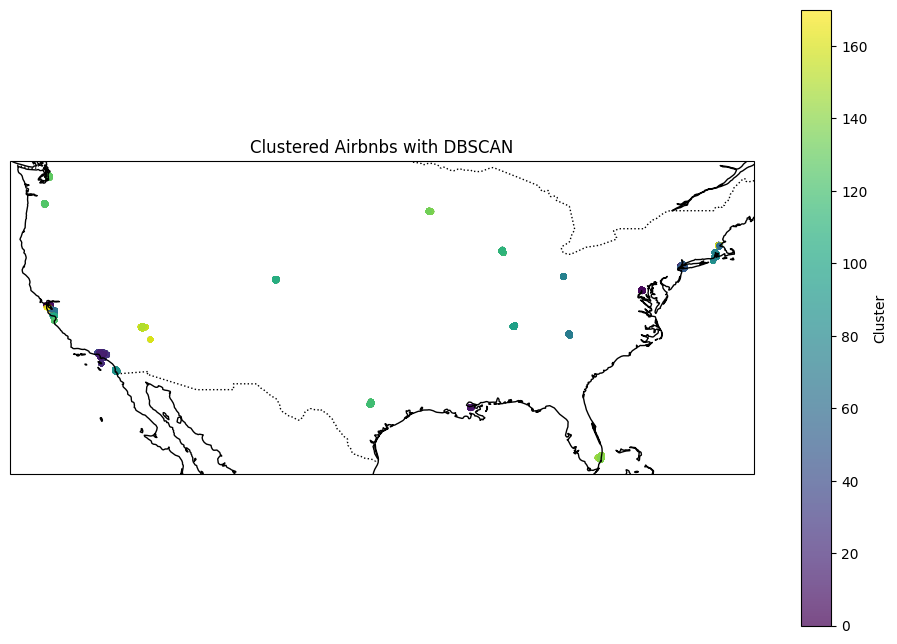

In [84]:
# Plotting the clusters on a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.set_title("Clustered Airbnbs with DBSCAN")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Scatter the points, color them by cluster
scatter = ax.scatter(
    airbnbs_df['longitude'], airbnbs_df['latitude'], c=airbnbs_df['cluster'], 
    cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7
)

# Add a colorbar to indicate the cluster labels
plt.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()


Seems like the clustering worked out and the clusters are pretty balanced and really look like clusters on the map. Next up, some feature engineering.

In [85]:
cluster_n = airbnbs_df["cluster"].unique()

cluster_counts = airbnbs_df.groupby('cluster').size()
average_datapoints_per_cluster = cluster_counts.mean()

print("Number of possible nodes:", max(cluster_n))
print("Number of datapoints in total:", len(airbnbs_df))
print(f"Average number of data points per cluster: {average_datapoints_per_cluster:.2f}")

Number of possible nodes: 170
Number of datapoints in total: 175410
Average number of data points per cluster: 1025.79


Next up, we should create a graph from the data with carefully chosen edges. Two nodes are connected if they are within 35km radius from each other. So in Chapter 7, the vector representation are the longitude and latitude of each node center, and the discrepancy between nodes is measured as Euclidean distance. The graph is undirected and unweighted.

In [86]:

G = nx.Graph()

clusters = airbnbs_df['cluster'].unique()
G.add_nodes_from(clusters)

for C in clusters:
    cluster_data = airbnbs_df[airbnbs_df["cluster"] == C] 
    X = airbnbs_df.drop(columns=['price', 'id']) 
    centre = cluster_centers.iloc[C].tolist()[1:]
    y = airbnbs_df['price']
    G.nodes[C]["X"] = X
    G.nodes[C]["y"] = y
    G.nodes[C]["center"] = centre
    
from geopy.distance import geodesic

threshold_km = 35

for C1 in clusters:
    for C2 in clusters:
        if C1 >= C2:
            continue
        coord1 = tuple(G.nodes[C1]["center"])
        coord2 = tuple(G.nodes[C2]["center"])
        dist_km = geodesic(coord1, coord2).kilometers
        if dist_km < threshold_km:
            G.add_edge(C1, C2, weight=((40-dist_km)/100.0)) # weight is smaller if the nodes is more far


isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)


In [87]:
import folium
from folium import plugins

all_coords = [G.nodes[C]["center"] for C in G.nodes]
avg_lat = sum([c[0] for c in all_coords]) / len(all_coords)
avg_lon = sum([c[1] for c in all_coords]) / len(all_coords)

m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

for node in G.nodes:
    lat, lon = G.nodes[node]["center"]
    popup_info = f"Cluster {node}"
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color='blue',
        fill=True,
        fill_color='skyblue',
        fill_opacity=0.9,
        popup=popup_info,

    ).add_to(m)

for u, v, data in G.edges(data=True):
    coord_u = G.nodes[u]["center"]
    coord_v = G.nodes[v]["center"]
    folium.PolyLine(locations=[coord_u, coord_v],
                    color='gray',
                    weight=2,
                    tooltip=f"{data['weight']:.1f} km").add_to(m)

minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

m


In [94]:
# Extract features (X) and target (y) for node 0
X = G.nodes[0]['X']
y = G.nodes[0]['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [97]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")


RMSE: 840987.90
